# Locating lung mask's center

In this notebook we will describe the idea behind the centroid relocation performed in the project.

You will need a slice from both a CT image and its corresponding masks. Use the notebook **get_slice.ipynb**, located in this same folder, to get the slice you need.

First of all, import the required libraries:

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import center_of_mass

These variables store the path of the slices (image and masks) we are going to work with:

In [2]:
data_folder_path = Path('data')
image_name = 'coronacases_001'
slice_number = 98
image_file_path = Path(f'{image_name}_image_slice_{slice_number}.npy')
masks_file_path = Path(f'{image_name}_masks_slice_{slice_number}.npy')
image_slice_path = data_folder_path / image_file_path
masks_slice_path = data_folder_path / masks_file_path

Let's load the image slice:

In [3]:
image_slice = np.load(image_slice_path)
image_slice.shape

(512, 512)

Now, let's load the masks slice:

In [4]:
masks_slice = np.load(masks_slice_path)
masks_slice.shape

(512, 512)

Before working with the slice and the masks, let's transform them as described in the notebook **coordinates_conventions.ipynb**:

In [5]:
image_slice = image_slice.swapaxes(0, 1)
masks_slice = masks_slice.swapaxes(0, 1)

We will use the row, columns coordinates convention.

Let's calculate the center of mass of each mask. The number of masks is not fixed, and it could be that no masks were saved to the file, because the organ being segmented was not present in the image:

In [6]:
masks_indexes = np.unique(masks_slice)
print(f'Masks values: {masks_indexes}')

masks_centers_of_mass = []
if len(masks_indexes) > 1:
    for mask_index in np.arange(start=1, stop=masks_indexes.max() + 1):
        mask = masks_slice == mask_index
        mask_center_of_mass = center_of_mass(mask)
        masks_centers_of_mass.append(mask_center_of_mass)

masks_centers_of_mass = np.array(masks_centers_of_mass).astype(np.uint)
print(f'Masks centers of mass: {masks_centers_of_mass}')

Masks values: [0 1 2]
Masks centers of mass: [[292 339]
 [298 167]]


Now, let's show those centers of mass. To make sure everything makes sense, only the mask marked with ones and its center of mass will be shown.

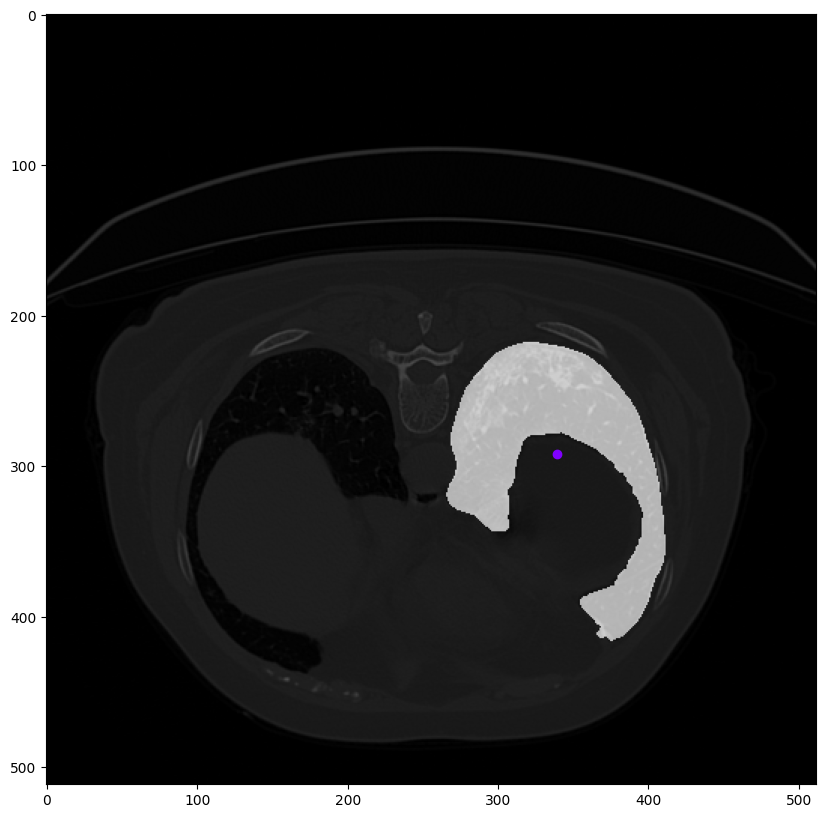

In [7]:
mask_index = 0
mask = masks_slice == mask_index + 1
mask_center_of_mass = masks_centers_of_mass[mask_index]

plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(image_slice)
plt.imshow(mask, alpha=0.7)
colors = plt.colormaps['rainbow'](np.linspace(0, 1, len(masks_centers_of_mass) + 1))
plt.scatter(x=mask_center_of_mass[1], y=mask_center_of_mass[0], color=colors[0])
plt.show()

Coronacases' CT scans are rotated, showing the bed in the upper part of the screen.

Slice 98 is a very particular one. The lung at the left of the previous image (not the one shown above) is outside the lung and surrounded by it at every direction.

We are going to use the center of mass shown above as a seed. Now, let's look at the number of mask points above, below, left and right of the center of mass:

In [9]:
print(f'mask: {mask.shape}')

mask_center_of_mass = masks_centers_of_mass[mask_index]
row = int(mask_center_of_mass[0])
column = int(mask_center_of_mass[1])

print(f'mask_center_of_mass: {mask_center_of_mass}')
print(f'row, column: {row}, {column}')

mask_points_left = mask[row, :column]
mask_points_right = mask[row, column + 1:]
mask_points_above = mask[:row, column]
mask_points_below = mask[row + 1:, column]

print(f'Points left: {len(mask_points_left)}')
print(f'Points right: {len(mask_points_right)}')
print(f'Points above: {len(mask_points_above)}')
print(f'Points below: {len(mask_points_below)}')

print(f'Mask points left: {np.sum(mask_points_left)}')
print(f'Mask points right: {np.sum(mask_points_right)}')
print(f'Mask points above: {np.sum(mask_points_above)}')
print(f'Mask points below: {np.sum(mask_points_below)}')


mask: (512, 512)
mask_center_of_mass: [292 339]
row, column: 292, 339
Points left: 339
Points right: 172
Points above: 292
Points below: 219
Mask points left: 44
Mask points right: 34
Mask points above: 59
Mask points below: 0


In this particular clase, the segment with more mask points is the one above the center of mass. Keep in mind the image is originally upside down. Let's move the center of mass above, so it is in the middle of said segment:

In [10]:
mask_segment = np.where(mask_points_above == True)[0]
mask_segment_center_index = len(mask_segment) // 2
mask_segment_center = int(mask_segment[mask_segment_center_index])
new_point = mask_segment_center, column

new_row = new_point[0]
new_column = new_point[1]

print(f'new row: {new_row}')
print(f'new column: {new_column}')

new row: 249
new column: 339


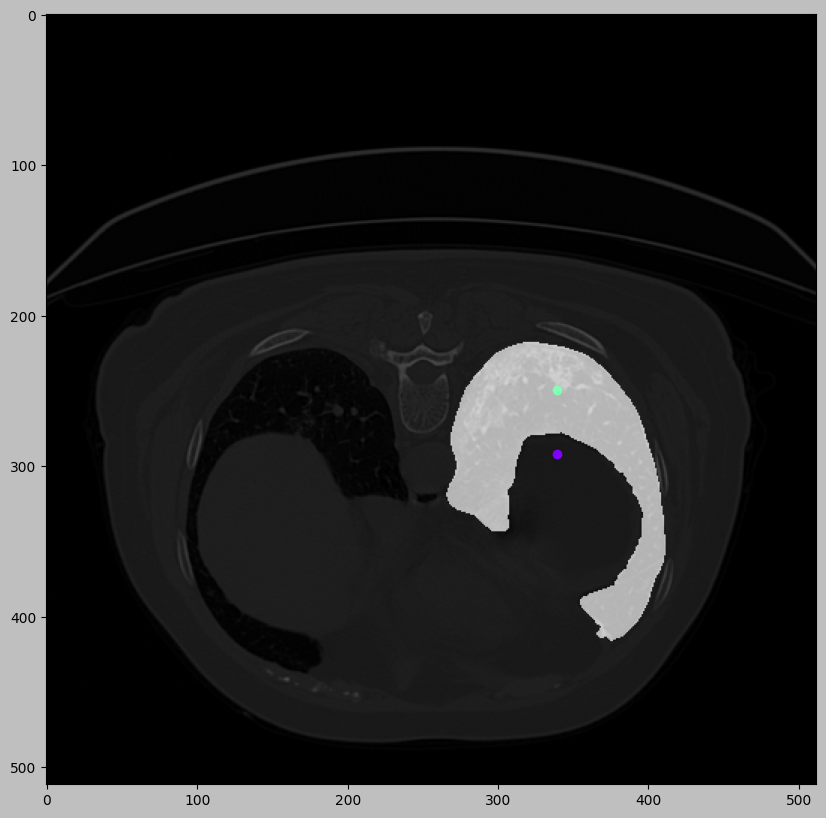

In [14]:
plt.figure(figsize=(10, 10))
plt.style.use('grayscale')
plt.imshow(image_slice)
plt.imshow(mask, alpha=0.7)

colors = plt.colormaps['rainbow'](np.linspace(0, 1, len(masks_centers_of_mass) + 1))
plt.scatter(column, row, color=colors[0])
plt.scatter(new_column, new_row, color=colors[1])

The full code for this and other related operations is in the file **image_slice.py**.
